In [19]:
from __future__ import division

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
#matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']

import os, glob, time, sys, functools
import corner
import numpy as np

import scipy
import scipy.constants as sc
import scipy.integrate as si
import scipy.signal as ssig
import scipy.interpolate as scint
import scipy.linalg as sl

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [20]:
import libstempo as T2
from libstempo import toasim as LT
from libstempo import plot as LP
from libstempo import eccUtils as eu

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import selections
from enterprise.signals import signal_base
import enterprise.signals.signal_base as base
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
from enterprise.signals import utils
from enterprise import constants as const

import enterprise_extensions as ee
from enterprise_extensions import models, model_utils, blocks

In [153]:
class PTABlockGibbs(object):
    
    """Gibbs-based pulsar-timing periodogram analysis.
    
    Based on:
    
        Article by van Haasteren & Vallisneri (2014),
        "New advances in the Gaussian-process approach 
        to pulsar-timing data analysis",
        Physical Review D, Volume 90, Issue 10, id.104012
        arXiv:1407.1838
        
        Code based on https://github.com/jellis18/gibbs_student_t
        
    Authors: 
    
        S. R. Taylor
    
    Example usage:
    
        > gibbs = PTABlockGibbs(pta, hypersample='conditional')
        > x0 = x0 = np.concatenate([p.sample().flatten() for p in gibbs.params])
        > gibbs.sample(x0, outdir='./', 
                       niter=10000, resume=False)
        
     
    """
    
    def __init__(self, pta, hypersample='conditional'):
        """
        Parameters
        -----------
        pta : object
            instance of a pta object for a single pulsar
        hypersample: string
            method to draw free spectral coefficients from conditional posterior
            ('conditional' = analytic; 'mh' = short MCMC chain)
        """

        self.pta = pta
        self.hypersample = hypersample
        if np.any(['basis_ecorr' in key for 
                   key in self.pta._signal_dict.keys()]):
            pass
        else:
            print('ERROR: Gibbs outlier analysis must use basis_ecorr, not kernel ecorr')

        # For now assume one pulsar
        self._residuals = self.pta.get_residuals()[0]

        # auxiliary variable stuff
        xs = [p.sample() for p in pta.params]
        self._b = np.zeros(self.pta.get_basis(xs)[0].shape[1])

        # for caching
        self.TNT = None
        self.d = None
        
        # grabbing priors on free spectral power values
        for ct, par in enumerate([p.name for p in self.params]):
            if 'rho' in par: ind = ct
        rho_priors = str(self.params[ct].params[0])
        rho_priors = rho_priors.split('(')[1].split(')')[0].split(', ')

        self.rhomin, self.rhomax = (10**(2*float(rho_priors[0].split('=')[1])), 
                                    10**(2*float(rho_priors[1].split('=')[1])))
        
        # find number of non-GW basis coefficients (timing model, ecorr, etc)
        ct = 0
        for sig in self.pta.signals:
            if 'linear_timing_model' in sig or 'ecorr' in sig:
                if 'marginalizing' in sig: pass
                else: ct += self.pta.signals[sig].get_basis().shape[1]
            else:
                pass
        self.gwid = ct
            
    @property
    def params(self):
        ret = []
        for param in self.pta.params:
            ret.append(param)
        return ret
    
    @property
    def param_names(self):
        ret = []
        for p in self.params:
            if p.size:
                for ii in range(0, p.size):
                    ret.append(p.name + "_{}".format(ii))
            else:
                ret.append(p.name)
        return ret
    
    def map_params(self, xs):
        ret = {}
        ct = 0
        for p in self.params:
            n = p.size if p.size else 1
            ret[p.name] = xs[ct : ct + n] if n > 1 else float(xs[ct])
            ct += n
        return ret


    def get_hyper_param_indices(self):
        ind = []
        for ct, par in enumerate(self.param_names):
            if 'ecorr' in par or 'log10_A' in par or 'gamma' in par or 'rho' in par:
                ind.append(ct)
        return np.array(ind)


    def get_white_noise_indices(self):
        ind = []
        for ct, par in enumerate(self.param_names):
            if 'efac' in par or 'equad' in par:
                ind.append(ct)
        return np.array(ind)


    def update_hyper_params(self, xs):

        # get hyper parameter indices
        hind = self.get_hyper_param_indices()
        
        # get initial log-likelihood and log-prior
        lnlike0, lnprior0 = self.get_lnlikelihood(xs), self.get_lnprior(xs)

        xnew = xs.copy()
        if self.hypersample == 'conditional':
            
            tau = self._b[self.gwid:]**2
            tau = (tau[::2] + tau[1::2]) / 2
            
            eta = np.random.uniform(0, 1-np.exp((tau/rhomax) - (tau/rhomin)))
            rhonew = tau / ((tau/rhomax) - np.log(1-eta))
            
            xnew[hind] = 0.5*np.log10(rhonew)
          
        else:
            
            for ii in range(10):

                # standard gaussian jump (this allows for different step sizes)
                q = xnew.copy()
                sigmas = 0.05 * len(hind)
                probs = [0.1, 0.15, 0.5, 0.15, 0.1]
                sizes = [0.1, 0.5, 1.0, 3.0, 10.0]
                scale = np.random.choice(sizes, p=probs)
                par = np.random.choice(hind, size=1) # only one hyper param at a time
                q[par] += np.random.randn(len(q[par])) * sigmas * scale

                # get log-like and log prior at new position
                lnlike1, lnprior1 = self.get_lnlikelihood(q), self.get_lnprior(q)

                # metropolis step
                diff = (lnlike1 + lnprior1) - (lnlike0 + lnprior0)
                if diff > np.log(np.random.rand()):
                    xnew = q
                    lnlike0 = lnlike1
                    lnprior0 = lnprior1
                else:
                    xnew = xnew
        
        return xnew


    def update_white_params(self, xs):

        # get white noise parameter indices
        wind = self.get_white_noise_indices()

        xnew = xs.copy()
        lnlike0, lnprior0 = self.get_lnlikelihood_white(xnew), self.get_lnprior(xnew)
        for ii in range(20):

            # standard gaussian jump (this allows for different step sizes)
            q = xnew.copy()
            sigmas = 0.05 * len(wind)
            probs = [0.1, 0.15, 0.5, 0.15, 0.1]
            sizes = [0.1, 0.5, 1.0, 3.0, 10.0]
            scale = np.random.choice(sizes, p=probs)
            par = np.random.choice(wind, size=1)
            q[par] += np.random.randn(len(q[par])) * sigmas * scale

            # get log-like and log prior at new position
            lnlike1, lnprior1 = self.get_lnlikelihood_white(q), self.get_lnprior(q)

            # metropolis step
            diff = (lnlike1 + lnprior1) - (lnlike0 + lnprior0)
            if diff > np.log(np.random.rand()):
                xnew = q
                lnlike0 = lnlike1
                lnprior0 = lnprior1
            else:
                xnew = xnew
        return xnew

    
    def update_b(self, xs): 

        # map parameter vector
        params = self.map_params(xs)

        # start likelihood calculations
        loglike = 0

        # get auxiliaries
        Nvec = self.pta.get_ndiag(params)[0]
        phiinv = self.pta.get_phiinv(params, logdet=False)[0]
        residuals = self._residuals

        T = self.pta.get_basis(params)[0]
        if self.TNT is None and self.d is None:
            self.TNT = np.dot(T.T, T / Nvec[:,None])
            self.d = np.dot(T.T, residuals/Nvec)
        #d = self.pta.get_TNr(params)[0]
        #TNT = self.pta.get_TNT(params)[0]

        # Red noise piece
        Sigma = self.TNT + np.diag(phiinv)

        try:
            u, s, _ = sl.svd(Sigma)
            mn = np.dot(u, np.dot(u.T, self.d)/s)
            Li = u * np.sqrt(1/s)
        except np.linalg.LinAlgError:

            Q, R = sl.qr(Sigma)
            Sigi = sl.solve(R, Q.T)
            mn = np.dot(Sigi, self.d)
            u, s, _ = sl.svd(Sigi)
            Li = u * np.sqrt(1/s)

        b = mn + np.dot(Li, np.random.randn(Li.shape[0]))

        return b

    
    def get_lnlikelihood_white(self, xs):

        # map parameters
        params = self.map_params(xs)
        matrix = self.pta.get_ndiag(params)[0]
        
        # Nvec and Tmat
        Nvec = matrix
        Tmat = self.pta.get_basis(params)[0]

        # whitened residuals
        mn = np.dot(Tmat, self._b)
        yred = self._residuals - mn

        # log determinant of N
        logdet_N = np.sum(np.log(Nvec))

        # triple product in likelihood function
        rNr = np.sum(yred**2/Nvec)

        # first component of likelihood function
        loglike = -0.5 * (logdet_N + rNr)

        return loglike


    def get_lnlikelihood(self, xs):

        # map parameter vector
        params = self.map_params(xs)
        
        # start likelihood calculations
        loglike = 0

        # get auxiliaries
        Nvec = self.pta.get_ndiag(params)[0]
        phiinv, logdet_phi = self.pta.get_phiinv(params, 
                                                 logdet=True)[0]
        residuals = self._residuals

        T = self.pta.get_basis(params)[0]
        if self.TNT is None and self.d is None:
            self.TNT = np.dot(T.T, T / Nvec[:,None])
            self.d = np.dot(T.T, residuals/Nvec)

        # log determinant of N
        logdet_N = np.sum(np.log(Nvec))

        # triple product in likelihood function
        rNr = np.sum(residuals**2/Nvec)

        # first component of likelihood function
        loglike += -0.5 * (logdet_N + rNr)

        # Red noise piece
        Sigma = self.TNT + np.diag(phiinv)

        try:
            cf = sl.cho_factor(Sigma)
            expval = sl.cho_solve(cf, self.d)
        except np.linalg.LinAlgError:
            return -np.inf

        logdet_sigma = np.sum(2 * np.log(np.diag(cf[0])))
        loglike += 0.5 * (np.dot(self.d, expval) - 
                          logdet_sigma - logdet_phi)

        return loglike

        
    def get_lnprior(self, params):
        # map parameter vector if needed
        params = params if isinstance(params, dict) else self.map_params(params)

        return np.sum([p.get_logpdf(params=params) for p in self.params])


    def sample(self, xs, outdir='./', niter=10000, resume=False):

        print(f'Creating chain directory: {outdir}')
        os.system(f'mkdir -p {outdir}')
        
        self.chain = np.zeros((niter, len(xs)))
        self.bchain = np.zeros((niter, len(self._b)))
        
        self.iter = 0
        startLength = 0
        xnew = xs
        if resume:
            print('Resuming from previous run...')
            # read in previous chains
            tmp_chains = []
            tmp_chains.append(np.loadtxt(f'{outdir}/chain.txt'))
            tmp_chains.append(np.loadtxt(f'{outdir}/bchain.txt'))
            
            # find minimum length
            minLength = np.min([tmp.shape[0] for tmp in tmp_chains])
            
            # take only the minimum length entries of each chain
            tmp_chains = [tmp[:minLength] for tmp in tmp_chains]
            
            # pad with zeros if shorter than niter
            self.chain[:tmp_chains[0].shape[0]] = tmp_chains[0]
            self.bchain[:tmp_chains[1].shape[0]] = tmp_chains[1]
            
            # set new starting point for sampling
            startLength = minLength
            xnew = self.chain[startLength-1]
            
        tstart = time.time()
        for ii in range(startLength, niter):
            self.iter = ii
            self.chain[ii, :] = xnew
            self.bchain[ii,:] = self._b
            
            if ii==0:
                self._b = self.update_b(xs)

            self.TNT = None
            self.d = None

            # update white parameters
            xnew = self.update_white_params(xnew)

            # update hyper-parameters
            xnew = self.update_hyper_params(xnew)

            # if accepted update quadratic params
            if np.all(xnew != self.chain[ii,-1]):
                self._b = self.update_b(xnew)


            if ii % 100 == 0 and ii > 0:
                sys.stdout.write('\r')
                sys.stdout.write('Finished %g percent in %g seconds.'%(ii / niter * 100, 
                                                                       time.time()-tstart))
                sys.stdout.flush()
                np.savetxt(f'{outdir}/chain.txt', self.chain[:ii+1, :])
                np.savetxt(f'{outdir}/bchain.txt', self.bchain[:ii+1, :])

In [201]:
def model_general(psrs, tm_var=False, tm_linear=False, tmparam_list=None,
                  tm_svd=False, tm_norm=True, noisedict=None, white_vary=False,
                  Tspan=None, modes=None, wgts=None, logfreq=False, nmodes_log=10,
                  common_psd='powerlaw', common_components=30,
                  log10_A_common=None, gamma_common=None,
                  common_logmin=None, common_logmax=None,
                  orf='crn', orf_names=None, orf_ifreq=0, leg_lmax=5,
                  upper_limit_common=None, upper_limit=False,
                  red_var=True, red_psd='powerlaw', red_components=30, upper_limit_red=None,
                  red_select=None, red_breakflat=False, red_breakflat_fq=None,
                  bayesephem=False, be_type='setIII_1980', is_wideband=False, use_dmdata=False,
                  dm_var=False, dm_type='gp', dm_psd='powerlaw', dm_components=30,
                  upper_limit_dm=None, dm_annual=False, dm_chrom=False, dmchrom_psd='powerlaw',
                  dmchrom_idx=4, gequad=False, coefficients=False, pshift=False,
                  select='backend', tm_marg=False, dense_like=False):
    """
    Reads in list of enterprise Pulsar instances and returns a PTA
    object instantiated with user-supplied options.
    :param tm_var: boolean to vary timing model coefficients.
        [default = False]
    :param tm_linear: boolean to vary timing model under linear approximation.
        [default = False]
    :param tmparam_list: list of timing model parameters to vary.
        [default = None]
    :param tm_svd: stabilize timing model designmatrix with SVD.
        [default = False]
    :param tm_norm: normalize the timing model design matrix, or provide custom
        normalization. Alternative to 'tm_svd'.
        [default = True]
    :param noisedict: Dictionary of pulsar noise properties. Can provide manually,
        or the code will attempt to find it.
        [default = None]
    :param white_vary: boolean for varying white noise or keeping fixed.
        [default = False]
    :param Tspan: timespan assumed for describing stochastic processes,
        in units of seconds. If None provided will find span of pulsars.
        [default = None]
    :param modes: list of frequencies on which to describe red processes.
        [default = None]
    :param wgts: sqrt summation weights for each frequency bin, i.e. sqrt(delta f).
        [default = None]
    :param logfreq: boolean for including log-spaced bins.
        [default = False]
    :param nmodes_log: number of log-spaced bins below 1/T.
        [default = 10]
    :param common_psd: psd of common process.
        ['powerlaw', 'spectrum', 'turnover', 'turnover_knee,', 'broken_powerlaw']
        [default = 'powerlaw']
    :param common_components: number of frequencies starting at 1/T for common process.
        [default = 30]
    :param log10_A_common: value of fixed log10_A_common parameter for
        fixed amplitude analyses.
        [default = None]
    :param gamma_common: fixed common red process spectral index value. By default we
        vary the spectral index over the range [0, 7].
        [default = None]
    :param common_logmin: specify lower prior for common psd. This is a prior on log10_rho
        if common_psd is 'spectrum', else it is a prior on log amplitude
    :param common_logmax: specify upper prior for common psd. This is a prior on log10_rho
        if common_psd is 'spectrum', else it is a prior on log amplitude
    :param orf: comma de-limited string of multiple common processes with different orfs.
        [default = crn]
    :param orf_names: comma de-limited string of process names for different orfs. Manual
        control of these names is useful for embedding model_general within a hypermodel
        analysis for a process with and without hd correlations where we want to avoid
        parameter duplication.
        [default = None]
    :param orf_ifreq:
        Frequency bin at which to start the Hellings & Downs function with
        numbering beginning at 0. Currently only works with freq_hd orf.
        [default = 0]
    :param leg_lmax:
        Maximum multipole of a Legendre polynomial series representation
        of the overlap reduction function.
        [default = 5]
    :param upper_limit_common: perform upper limit on common red noise amplitude. Note
        that when perfoming upper limits it is recommended that the spectral index also
        be fixed to a specific value.
        [default = False]
    :param upper_limit: apply upper limit priors to all red processes.
        [default = False]
    :param red_var: boolean to switch on/off intrinsic red noise.
        [default = True]
    :param red_psd: psd of intrinsic red process.
        ['powerlaw', 'spectrum', 'turnover', 'tprocess', 'tprocess_adapt', 'infinitepower']
        [default = 'powerlaw']
    :param red_components: number of frequencies starting at 1/T for intrinsic red process.
        [default = 30]
    :param upper_limit_red: perform upper limit on intrinsic red noise amplitude. Note
        that when perfoming upper limits it is recommended that the spectral index also
        be fixed to a specific value.
        [default = False]
    :param red_select: selection properties for intrinsic red noise.
        ['backend', 'band', 'band+', None]
        [default = None]
    :param red_breakflat: break red noise spectrum and make flat above certain frequency.
        [default = False]
    :param red_breakflat_fq: break frequency for 'red_breakflat'.
        [default = None]
    :param bayesephem: boolean to include BayesEphem model.
        [default = False]
    :param be_type: flavor of bayesephem model based on how partials are computed.
        ['orbel', 'orbel-v2', 'setIII', 'setIII_1980']
        [default = 'setIII_1980']
    :param is_wideband: boolean for whether input TOAs are wideband TOAs. Will exclude
        ecorr from the white noise model.
        [default = False]
    :param use_dmdata: whether to use DM data (WidebandTimingModel) if is_wideband.
        [default = False]
    :param dm_var: boolean for explicitly searching for DM variations.
        [default = False]
    :param dm_type: type of DM variations.
        ['gp', other choices selected with additional options; see below]
        [default = 'gp']
    :param dm_psd: psd of DM GP.
        ['powerlaw', 'spectrum', 'turnover', 'tprocess', 'tprocess_adapt']
        [default = 'powerlaw']
    :param dm_components: number of frequencies starting at 1/T for DM GP.
        [default = 30]
    :param upper_limit_dm: perform upper limit on DM GP. Note that when perfoming
        upper limits it is recommended that the spectral index also be
        fixed to a specific value.
        [default = False]
    :param dm_annual: boolean to search for an annual DM trend.
        [default = False]
    :param dm_chrom: boolean to search for a generic chromatic GP.
        [default = False]
    :param dmchrom_psd: psd of generic chromatic GP.
        ['powerlaw', 'spectrum', 'turnover']
        [default = 'powerlaw']
    :param dmchrom_idx: spectral index of generic chromatic GP.
        [default = 4]
    :param gequad: boolean to search for a global EQUAD.
        [default = False]
    :param coefficients: boolean to form full hierarchical PTA object;
        (no analytic latent-coefficient marginalization)
        [default = False]
    :param pshift: boolean to add random phase shift to red noise Fourier design
        matrices for false alarm rate studies.
        [default = False]
    :param tm_marg: Use marginalized timing model. In many cases this will speed
        up the likelihood calculation significantly.
    :param dense_like: Use dense or sparse functions to evalute lnlikelihood
    Default PTA object composition:
        1. fixed EFAC per backend/receiver system (per pulsar)
        2. fixed EQUAD per backend/receiver system (per pulsar)
        3. fixed ECORR per backend/receiver system (per pulsar)
        4. Red noise modeled as a power-law with 30 sampling frequencies
           (per pulsar)
        5. Linear timing model (per pulsar)
        6. Common-spectrum uncorrelated process modeled as a power-law with
           30 sampling frequencies. (global)
    """

    amp_prior = 'uniform' if upper_limit else 'log-uniform'
    gp_priors = [upper_limit_red, upper_limit_dm, upper_limit_common]
    if all(ii is None for ii in gp_priors):
        amp_prior_red = amp_prior
        amp_prior_dm = amp_prior
        amp_prior_common = amp_prior
    else:
        amp_prior_red = 'uniform' if upper_limit_red else 'log-uniform'
        amp_prior_dm = 'uniform' if upper_limit_dm else 'log-uniform'
        amp_prior_common = 'uniform' if upper_limit_common else 'log-uniform'

    # timing model
    if not tm_var and not use_dmdata:
        if tm_marg:
            s = gp_signals.MarginalizingTimingModel()
        else:
            s = gp_signals.TimingModel(use_svd=tm_svd, normed=tm_norm,
                                       coefficients=coefficients)
    
    # find the maximum time span to set GW frequency sampling
    if Tspan is not None:
        Tspan = Tspan
    else:
        Tspan = model_utils.get_tspan(psrs)

    # common red noise block
    crn = []
    if orf_names is None:
        orf_names = orf
    for elem, elem_name in zip(orf.split(','), orf_names.split(',')):
        if elem == 'zero_diag_bin_orf' or elem == 'zero_diag_legendre_orf':
            log10_A_val = log10_A_common
        else:
            log10_A_val = None
        crn.append(blocks.common_red_noise_block(psd=common_psd, prior=amp_prior_common, Tspan=Tspan,
                                          components=common_components,
                                          log10_A_val=log10_A_val, gamma_val=gamma_common,
                                          delta_val=None, orf=elem, name='gw_{}'.format(elem_name),
                                          orf_ifreq=orf_ifreq, leg_lmax=leg_lmax,
                                          coefficients=coefficients, pshift=pshift, pseed=None,
                                          logmin=common_logmin, logmax=common_logmax))
        # orf_ifreq only affects freq_hd model.
        # leg_lmax only affects (zero_diag_)legendre_orf model.
    crn = functools.reduce((lambda x, y: x+y), crn)
    s += crn

    # adding white-noise, and acting on psr objects
    models = []
    for p in psrs:
        if 'NANOGrav' in p.flags['pta'] and not is_wideband:
            s2 = s + blocks.white_noise_block(vary=white_vary, inc_ecorr=True,
                                       gp_ecorr=True, select=select)
            models.append(s2(p))
        else:
            s4 = s + blocks.white_noise_block(vary=white_vary, inc_ecorr=False,
                                   select=select)
            models.append(s4(p))

    # set up PTA
    if dense_like:
        pta = signal_base.PTA(models, lnlikelihood=signal_base.LogLikelihoodDenseCholesky)
    else:
        pta = signal_base.PTA(models)

    return pta

## IPTA MDC Example

In [24]:
parfiles = sorted(glob.glob('/Users/taylosr8/Research/repos/enterprise/tests/data/mdc1/*.par'))
timfiles = sorted(glob.glob('/Users/taylosr8/Research/repos/enterprise/tests/data/mdc1/*.tim'))

In [25]:
epsrs = []
for p,t in zip(parfiles, timfiles):
    epsrs.append(Pulsar(p,t))

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [158]:
pta = model_general([epsrs[0]], red_var=False, 
                     white_vary=True, 
                     common_psd='spectrum', common_components=10, 
                    select=None, tm_marg=False)

In [159]:
gibbs = PTABlockGibbs(pta=pta, hypersample='conditional')

ERROR: Gibbs outlier analysis must use basis_ecorr, not kernel ecorr


In [160]:
x0 = np.concatenate([p.sample().flatten() for p in gibbs.params])

In [161]:
gibbs.sample(params, outdir='./gibbs_ipta_mdc/', 
             niter=10000, resume=False)

Creating chain directory: ./gibbs_ipta_mdc/
Finished 99 percent in 225.501 seconds.

In [162]:
chain_gibbs = np.loadtxt('./gibbs_ipta_mdc/chain.txt')
chain_mhmcmc = np.loadtxt('./gibbs_ipta_mdc_mhmcmc/chain.txt')

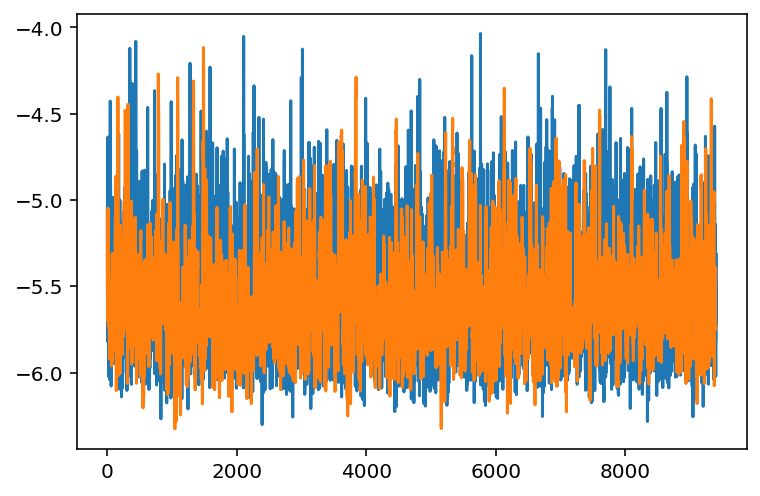

In [163]:
idx = 2
plt.plot(chain_gibbs[500:,idx])
plt.plot(chain_mhmcmc[500:,idx])

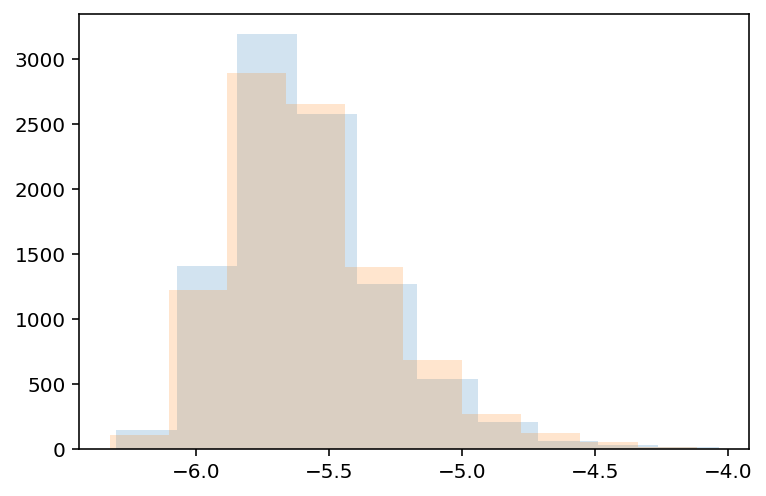

In [164]:
plt.hist(chain_gibbs[500:,idx], alpha=0.2);
plt.hist(chain_mhmcmc[500:,idx], alpha=0.2);

In [165]:
import acor
for ii in range(10):
    print(acor.acor(chain_gibbs[500:,2+ii])[0], acor.acor(chain_mhmcmc[500:,2+ii])[0])

1.83313186264758 9.371994806357986
13.477585554239855 22.621613043990138
1.392542128917813 9.195165917156123
20.504969105477617 18.86193514114728
32.25686751512652 17.830080919689642
8.97485035930145 14.732415015575402
13.49887180799157 38.00000203659036
8.155903358834399 17.103057057191283
6.752069241892965 12.31615700028519
7.053029715390668 13.041110369145654


In [166]:
chain_gibbs_b = np.loadtxt('./gibbs_ipta_mdc/bchain.txt')

In [167]:
chain_gibbs_b.shape

(9901, 28)

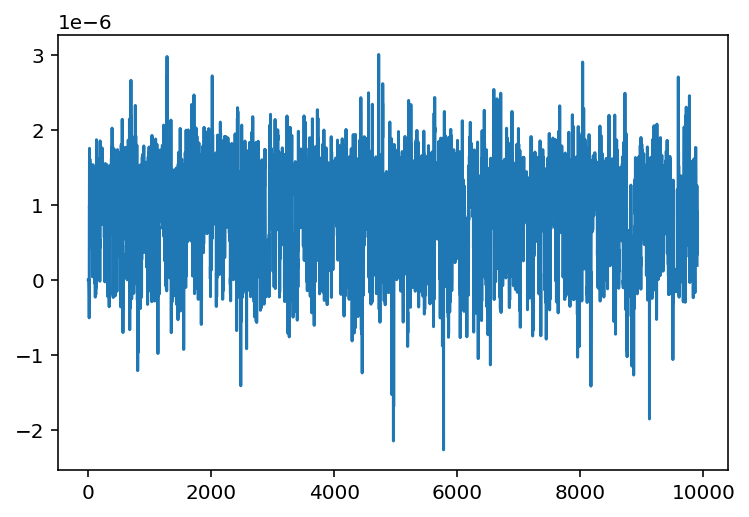

In [176]:
plt.plot(chain_gibbs_b[:,8])

## More realistic example

In [185]:
epsr = Pulsar('/Users/taylosr8/Research/repos/enterprise/tests/data/J1713+0747_NANOGrav_9yv1.t2.gls.par',
              '/Users/taylosr8/Research/repos/enterprise/tests/data/J1713+0747_NANOGrav_9yv1.tim')

In [202]:
pta = model_general([epsr], red_var=False, 
                    white_vary=True, 
                    common_psd='spectrum', common_components=10, 
                    select='backend', tm_marg=False)

In [203]:
pta.params

[J1713+0747_L-wide_ASP_efac:Uniform(pmin=0.01, pmax=10.0),
 J1713+0747_L-wide_ASP_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1713+0747_L-wide_PUPPI_efac:Uniform(pmin=0.01, pmax=10.0),
 J1713+0747_L-wide_PUPPI_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1713+0747_Rcvr1_2_GASP_efac:Uniform(pmin=0.01, pmax=10.0),
 J1713+0747_Rcvr1_2_GASP_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1713+0747_Rcvr1_2_GUPPI_efac:Uniform(pmin=0.01, pmax=10.0),
 J1713+0747_Rcvr1_2_GUPPI_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1713+0747_Rcvr_800_GASP_efac:Uniform(pmin=0.01, pmax=10.0),
 J1713+0747_Rcvr_800_GASP_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1713+0747_Rcvr_800_GUPPI_efac:Uniform(pmin=0.01, pmax=10.0),
 J1713+0747_Rcvr_800_GUPPI_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1713+0747_S-wide_ASP_efac:Uniform(pmin=0.01, pmax=10.0),
 J1713+0747_S-wide_ASP_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1713+0747_S-wide_PUPPI_efac:Uniform(pmin=0.01, pmax=10.0),
 J1713+0747_S-wide_PUPPI_log10_equad:Uniform(pmin=

In [211]:
gibbs = PTABlockGibbs(pta=pta, hypersample='conditional')

In [212]:
x0 = np.concatenate([p.sample().flatten() for p in gibbs.params])

In [213]:
gibbs.sample(x0, outdir='./gibbs_nano9_1713/', 
             niter=10000, resume=False)

Creating chain directory: ./gibbs_nano9_1713/


ValueError: shape mismatch: value array of shape (10,) could not be broadcast to indexing result of shape (18,)

In [215]:
pta.get_basis()[0].shape

(15257, 673)

In [217]:
for sig in pta.signals:
    try:
        print(pta.signals[sig].name, pta.signals[sig].get_basis().shape)
    except:
        print(pta.signals[sig].name)

J1713+0747_linear_timing_model (15257, 129)
J1713+0747_gw_crn (15257, 20)
J1713+0747_efac
J1713+0747_equad
J1713+0747_basis_ecorr (15257, 524)


In [218]:
ct = 0
for sig in pta.signals:
    if 'linear_timing_model' in sig or 'ecorr' in sig:
        if 'marginalizing' in sig: pass
        else: ct += self.pta.signals[sig].get_basis().shape[1]
    else:
        pass
self.gwid = ct

653

In [220]:
pta.get_basis()[0]

array([[ 0.00809591,  0.00793454, -0.00793436, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00809591,  0.00793454, -0.00793436, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00809591,  0.00793454, -0.00793436, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.00809591, -0.0065193 , -0.00940972, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00809591, -0.0065193 , -0.00940972, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00809591, -0.0065193 , -0.00940972, ...,  0.        ,
         0.        ,  0.        ]])

In [226]:
pta._signal_dict['J1713+0747_gw_crn'].get_basis()

array([[-0.83610242, -0.54857338,  0.91732705, ...,  0.87101873,
        -0.4587743 , -0.88855283],
       [-0.83610242, -0.54857338,  0.91732705, ...,  0.87101873,
        -0.4587743 , -0.88855283],
       [-0.83610242, -0.54857338,  0.91732705, ...,  0.87101873,
        -0.4587743 , -0.88855283],
       ...,
       [-0.83610242, -0.54857338,  0.91732705, ...,  0.87101873,
        -0.4587743 , -0.88855283],
       [-0.83610242, -0.54857338,  0.91732705, ...,  0.87101873,
        -0.4587743 , -0.88855283],
       [-0.83610242, -0.54857338,  0.91732705, ...,  0.87101873,
        -0.4587743 , -0.88855283]])